# 심층 신경망 훈련
- 수 많은 은닉층과 뉴런을 가진 심층 신경망을 훈련시킬 때 직면하는 문제들
    - 1. 까다로운 그래디언트 소실(또는 폭주) 문제에 직면할 것(이 현상은 심층 신경망에 영향을 주며 하위층이 훈련하기 매우 어려워짐)
    - 2. 이런 대규모 신경망에서는 훈련이 극단적으로 느려질 것
    - 3. 수백만 개의 파라미터를 가진 모델은 훈련 세트에 과대적합될 위험이 큼

In [1]:
# 공통
import numpy as np
import pandas as pd
import os

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
# 한글출력
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

## 11.1 그래디언트 소실과 폭주 문제
- 그래디언트 소실은 알고리즘이 하위층으로 진행됨에 따라 그래디언트가 점점작아져 하위층의 연결 가중치는 실제 변경되지 않는 것(주로 심층신경망)
- 그래디언트 폭주는 그래디언트가 점점 켜져 여러 개의 층이 비정상적으로 큰 가중치로 갱신되며 알고리즘이 발산하는 것(주로 순환신경망)

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


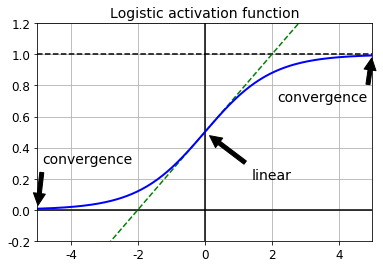

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('convergence', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center") # 수렴
plt.annotate('convergence', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center") # 수렴
plt.annotate('linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center") # 선형
plt.grid(True)
plt.title("Logistic activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])
plt.show() # 로지스틱 함수는 수렴(convergence)인 경우 기울기가 0에 가까워짐 -> 하위층에서는 그래디언트가 0에 가까워 전달이 안되는 것

#### 11.1.1 세이비어 초기화와 He 초기화
- 이런 그래디언트 문제의 해결책으로, 예측을 할 때는 정방향으로, 그래디언트를 역전파할 때는 역뱡항으로 양방향 신호가 적절히 흘러야 한다고 주장
    - 적절한 신호가 흐르기 위해 각 층의 출력에 대한 분산이 입력에 대한 분산과 같아야 함
    - 역방향에서 층을 통과하기 전과 후의 그래디언트 분산이 동일해야 함
- 층의 입력과 출력 연결 개수가 같지 않다면 이 두 가지를 보장할 수 없음
    - 이를 해결하기 위해 무작위 초기화하는 것을 선택(이를 세이비어 초기화, 글로럿 초기화라고 함)
    - 10장에서 사용한 tf.layer.dence는 기본적으로 세이비어 초기화를 사용함

In [4]:
import tensorflow as tf

reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

C:\Users\Yoo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Yoo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Yoo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Yoo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type

In [5]:
he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name="hidden1") # 세이비어가 아닌 He 초기화 방식(he_init)으로 바꿀 수 있음

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


#### 11.1.2 수렴하지 않는 활성화 함수
- 활성화 함수를 잘못 선택하면 자칫 그래디언트 소실이나 폭주의 문제로 이어질 수 있음
- ReLU의 경우 양숫값에서 수렴하지 않지만, 완벽하지는 않음
    - 음수가 되면 그래디언트가 0이 되기 때문에 죽은 ReLU로 알려진 훈련하는 동안 일부 뉴런이 0 이외의 다른 값을 출력하지 않는 문제가 발생함
- 이런 문제를 해결하기 위해 LeakyReLU 같은 ReLU 변종 함수를 사용
    - ReLU는 음수일 경우 뉴런이 계속 0을 출력하여 살아나기 힘들었지만, LeakyReLU는 일반적으로 0.01의 기울기를 가져 다시 깨어날 가능성을 가짐
- 또 다른 변종 함수 ELU는 다른 모든 시험에서 ReLU를 앞선 성능을 보여줌(다만, 속도는 ReLU보다 느림)
    - 1. z < 0일 때 음수값이 들어오므로 활성화 함수의 평균 출력이 0에 더 가까워짐(이는 그래디언트 소실 문제를 완화해줌)
    - 2. z < 0이어도 그래디언트가 0이 아니므로 죽은 뉴런을 만들지 않음
    - 3. 하이퍼파리미터 알파 = 1일 때 이 함수는 z = 0에서 급격히 변동하지 않고 z = 0을 포함해 모든 구간에서 매끄러워 경사 하강법 속도를 높임

##### LeakyReLU

In [6]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

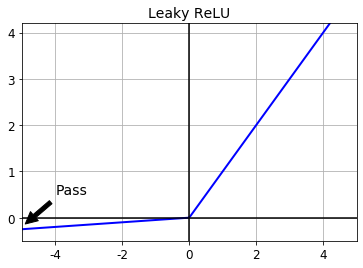

In [7]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Pass', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center") # 통과
plt.title("Leaky ReLU", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])
plt.show()

##### 텐서플로를 통한 LeakyReLU 구현

In [8]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [9]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1") # 활성화 함수 LeakyReLU 지정

In [10]:
# 그래프 정의
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"): # 은닉층 설정
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")  # 활성화 함수 leaky_relu 함수
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2") # 활성화 함수 leaky_relu 함수
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
    
with tf.name_scope("loss"): # 비용함수 설정
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
learning_rate = 0.01

with tf.name_scope("train"): # 역전파 훈련 설정
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"): # 평가 설정
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer() # 초기화
saver = tf.train.Saver() # 훈련 저장

In [11]:
# 데이터 로드
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [12]:
# 인덱스 셔플 함수
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [13]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, "배치 데이터 정확도:", acc_batch, "검증 세트 정확도:", acc_valid)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 배치 데이터 정확도: 0.86 검증 세트 정확도: 0.9044
5 배치 데이터 정확도: 0.94 검증 세트 정확도: 0.9494
10 배치 데이터 정확도: 0.92 검증 세트 정확도: 0.9656
15 배치 데이터 정확도: 0.94 검증 세트 정확도: 0.9714
20 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9764
25 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9776
30 배치 데이터 정확도: 0.98 검증 세트 정확도: 0.978
35 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9788


##### ELU

In [14]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

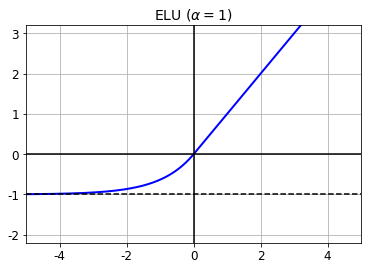

In [15]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

##### 텐서플로를 통한 ELU 구현

In [16]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [17]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")  # 활성화 함수를 tf.nn.elu 설정하여 텐서플로에서 ELU 구현

##### SELU
- 훈련할 때 SELU 활성화 함수를 사용한 완전 연결 신경망은 스스로 정규화
- 각 층의 출력은 훈련하는 동안 같은 평균과 분산을 유지하려는 경향이 있어 그래디언트 소실과 폭주 문제를 해결
- 이 활성화 함수는 심층 신경망에서 다른 활성화 함수보다 뛰어난 성능을 내므로 꼭 이 함수를 시도해야 함

In [18]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * elu(z, alpha)

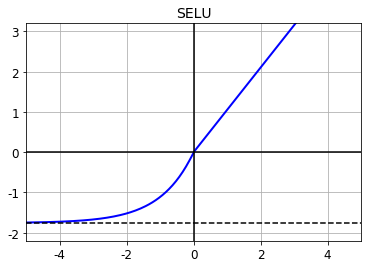

In [19]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

- 기본적으로 SELU 하이퍼파라미터(scale과 alpha)는 평균이 0, 표준 편차가 1에 가깝게 유지되도록 조정(입력도 평균이 0, 표준 편차가 1로 표준화되었다고 가정)
- 이 활성화 함수를 사용하면 100층으로 된 심층 신경망도 그래디언트 소실/폭주 문제없이 모든 층에서 대략 평균이 0이고 표준 편차가 1을 유지


In [20]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100))
for layer in range(100):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1/100))
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=1)
    stds = np.std(Z, axis=1)
    if layer % 10 == 0:
        print("층 {}: {:.2f} < 평균 < {:.2f}, {:.2f} < 표준 편차 < {:.2f}".format(
            layer, means.min(), means.max(), stds.min(), stds.max()))

층 0: -0.26 < 평균 < 0.27, 0.74 < 표준 편차 < 1.27
층 10: -0.24 < 평균 < 0.27, 0.74 < 표준 편차 < 1.27
층 20: -0.17 < 평균 < 0.18, 0.74 < 표준 편차 < 1.24
층 30: -0.27 < 평균 < 0.24, 0.78 < 표준 편차 < 1.20
층 40: -0.38 < 평균 < 0.39, 0.74 < 표준 편차 < 1.25
층 50: -0.27 < 평균 < 0.31, 0.73 < 표준 편차 < 1.27
층 60: -0.26 < 평균 < 0.43, 0.74 < 표준 편차 < 1.35
층 70: -0.19 < 평균 < 0.21, 0.75 < 표준 편차 < 1.21
층 80: -0.18 < 평균 < 0.16, 0.72 < 표준 편차 < 1.19
층 90: -0.19 < 평균 < 0.16, 0.75 < 표준 편차 < 1.20


##### 텐서플로를 통한 SELU 구현

In [21]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z))

In [22]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"): # 은닉층 설계
    hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name="hidden1") # 활성화 함수 selu 함수
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=selu, name="hidden2") # 활성화 함수 selu 함수
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"): # 비용함수 설정
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"): # 역전파 훈련 설정
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"): # 평가 설정
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 50

In [23]:
means = X_train.mean(axis=0, keepdims=True)
stds = X_train.std(axis=0, keepdims=True) + 1e-10
X_val_scaled = (X_valid - means) / stds

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_val_scaled, y: y_valid})
            print(epoch, "배치 데이터 정확도:", acc_batch, "검증 세트 정확도:", acc_valid)

    save_path = saver.save(sess, "./my_model_final_selu.ckpt")

0 배치 데이터 정확도: 0.88 검증 세트 정확도: 0.9232
5 배치 데이터 정확도: 0.98 검증 세트 정확도: 0.9576
10 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9666
15 배치 데이터 정확도: 0.96 검증 세트 정확도: 0.9684
20 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9692
25 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.969
30 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9692
35 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9698


#### 11.1.3 배치 정규화
- ReLU의 변종 함수를 사용하면 소실이나 폭주 문제를 크게 감소시킬 수 있지만, 훈련하는 동안 다시 발생하지 않으리란 보장은 없음
- 이를 위해서 배치 정규화 기법을 사용
    - 이 기법은 각 층에서 활성화 함수를 통과하기 전에 모델에 연산을 하나 추가함
    - 단순하게 입력 데이터의 평균을 0으로 만들고 정규화함(이를 위해서는 평균과 표준편차를 추정해야 함)
    - 각 층에서 두 개의 새로운 파라미터 결과값의 스케일을 조정하고 이동시킴
    - 두 개의 결과값은 하나는 스케일 조정을 위해, 다른 하나는 이동을 위해 필요함
    - 즉, 이 연산으로 모델이 층마다 입력 데이터의 최적 스케일과 평균을 학습
- 이 방법은 대부분 성능을 향상시킬 것이지만, 모델의 복잡도를 키워 시간이 오래 걸림

##### 텐서플로를 통한 배치 정규화 구현
- tf.nn.batch.normalization() 함수를 통해 입력값을 중앙에 정렬 및 정규화가 가능하지만, 이후 과정이 복잡함
- tf.layers.batch_normalization() 함수는 일련의 과정을 모두 처리해주므로 이 함수를 사용하는 것이 좋음

In [24]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name='training') # 훈련 동안에는 True, 이외에는 False

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1") # 완전 연결 층(활성화 함수 지정 X -> 정규화 층 이후 활성화 함수 지정하므로)
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9) # 정규화 층
bn1_act = tf.nn.elu(bn1) # 활성화 함수 층?

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2") # 완전 연결 층
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9) # 정규화 층
bn2_act = tf.nn.elu(bn2) # 활상화 함수 층?

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs") # 완전 연결 층
logits = tf.layers.batch_normalization(logits_before_bn, training=training, momentum=0.9) # 정규화 층

Instructions for updating:
Use keras.layers.batch_normalization instead.


In [25]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')

In [26]:
from functools import partial # partial ==> 같은 매개변수를 반복적으로 사용하지 않기 위한 모듈

my_batch_norm_layer = partial(tf.layers.batch_normalization, training=training, momentum=0.9) # 나만의 기준을 적용

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1) # my_batch_norm_layer 사용
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2) # my_batch_norm_layer 사용
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn) # my_batch_norm_layer 사용

In [27]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()

    my_batch_norm_layer = partial(tf.layers.batch_normalization, training=training, momentum=batch_norm_momentum) # 정규화 층 기준

    my_dense_layer = partial(tf.layers.dense, kernel_initializer=he_init) # 완전 연결 층 기준

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Use tf.cast instead.


In [28]:
n_epochs = 20
batch_size = 200

- 기존 실행 단계와 다른 두 가지
    - 1. 훈련하는 동안에는 batch_normalization() 함수에 의존하는 어떤 연산을 수행할 때마다 training 플레이스홀더를 True 설정
    - 2. batch_normalization() 함수는 이동 평균을 갱신하기 위해 매 훈련 단계에서 평가할 몇 개의 연산을 생성
        - 이 연산은 자동으로 UPDATE_OPS 컬렉션에 추가되므로 컬렉션에서 이 연산능 뽑아내어 훈련이 반복될 때마다 실행해야 함

In [29]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) # UPDATE_OPS에서 연산을 뽑아냄

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops], feed_dict={training: True, X: X_batch, y: y_batch}) # extra_update_ops 들어감
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt") # 층이 두 개뿐인 간단한 예제가 아닌 심층 신경망에서는 큰 차이를 만들 것

0 검증 세트 정확도: 0.8952
1 검증 세트 정확도: 0.9202
2 검증 세트 정확도: 0.9318
3 검증 세트 정확도: 0.9422
4 검증 세트 정확도: 0.9468
5 검증 세트 정확도: 0.954
6 검증 세트 정확도: 0.9568
7 검증 세트 정확도: 0.96
8 검증 세트 정확도: 0.962
9 검증 세트 정확도: 0.9638
10 검증 세트 정확도: 0.9662
11 검증 세트 정확도: 0.9682
12 검증 세트 정확도: 0.9672
13 검증 세트 정확도: 0.9696
14 검증 세트 정확도: 0.9706
15 검증 세트 정확도: 0.9704
16 검증 세트 정확도: 0.9718
17 검증 세트 정확도: 0.9726
18 검증 세트 정확도: 0.9738
19 검증 세트 정확도: 0.9742


In [30]:
# 변형
"""
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        training_op = optimizer.minimize(loss)
"""
# 만약 훈련 세트에서 UPDATE_OPS를 적용하면
"""
sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
"""
# 실행 단계에서 이렇게 시행할 수 있음

'\nsess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})\n'

##### 추가
- 훈련될 변수 개수가 전체 전역 변수 개수보다 적은데, 이는 이동 평균을 위한 변수는 훈련되는 변수가 아니기 때문
- 미리 학습한 신경망을 재사용할 경우(아래 참조) 이런 훈련되지 않는 변수를 놓쳐서는 안됨

In [31]:
[v.name for v in tf.trainable_variables()] # 훈련될 변수

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0']

In [32]:
[v.name for v in tf.global_variables()] # 전역 변수

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

#### 11.1.4 그래디언트 클리핑
- 그래디언트 폭주 문제를 줄이는 쉬운 방법은 역전파될 때 일정 임곗값을 넘어서지 못하게 그래디언트를 단순히 잘라내는 것
    - 순환 신경망에서는 일반적으로 널리 사용하지만 다른 경우에는 대부분 배치 정규화를 선호

In [33]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"): # 5개의 은닉층을 가짐
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [34]:
learning_rate = 0.01

threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss) # compute_gradients() 사용
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars] # clip_by_value() ==> 그래디언트 클리핑하는 연산을 생성
training_op = optimizer.apply_gradients(capped_gvs) # apply_gradients ==> 클리핑된 그래디언트를 적용하는 연산을 생성

In [35]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [36]:
n_epochs = 20
batch_size = 200

In [37]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 검증 세트 정확도: 0.2878
1 검증 세트 정확도: 0.7942
2 검증 세트 정확도: 0.8796
3 검증 세트 정확도: 0.9064
4 검증 세트 정확도: 0.9162
5 검증 세트 정확도: 0.922
6 검증 세트 정확도: 0.929
7 검증 세트 정확도: 0.9356
8 검증 세트 정확도: 0.9382
9 검증 세트 정확도: 0.9418
10 검증 세트 정확도: 0.9458
11 검증 세트 정확도: 0.9472
12 검증 세트 정확도: 0.9476
13 검증 세트 정확도: 0.9536
14 검증 세트 정확도: 0.9568
15 검증 세트 정확도: 0.9566
16 검증 세트 정확도: 0.9576
17 검증 세트 정확도: 0.9592
18 검증 세트 정확도: 0.9622
19 검증 세트 정확도: 0.9612


## 11.2 미리 훈련된 층 재사용하기
- 일반적으로 아주 큰 규모의 DNN을 처음부터 새로 훈련시키는 것은 좋은 방법이 아님
- 해결하려는 것과 비슷한 유형의 문제를 처리한 신경망이 있는지 찾아본 후, 그런 신경망의 하위층을 재사용하는 것이 좋음(전이 학습)

#### 11.2.1 텐서플로 모델 재사용하기
- import_meta_graph() 함수가 그래프 연산들을 로드하여 기본 그래프에 적재하고 모델의 상태를 복원할 수 있도록 Saver 객체를 반환
- 기본적으로 Saver 객체는 .meta 확장자를 가진 파일에 그래프 구조를 저장하므로 이 파일을 로드해야 함

In [38]:
reset_graph()

saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta") # import_meta_graph()를 통해 그래프 연산을 로드

In [39]:
# 다음으로 훈련해야 할 모든 연산을 가져와야 함(그래프 구조를 모를 때는 모든 연산을 출력해 볼 수 있음)
for op in tf.get_default_graph().get_operations():
    print(op.name)

X
y
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
dnn/hidden1/Relu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read
hidden2/bias/Initializer/zeros
hidden2/bias
hidden2/bias/Assign
hidden2/bias/read
dn

In [40]:
# 필요한 연산을 찾았다면 그래프의 get_operation_by_name()이나 get_tensor_by_name() 메서드를 사용하여 추출할 수 있음
X = tf.get_default_graph().get_tensor_by_name("X:0") # get_operation_by_name() 사용
y = tf.get_default_graph().get_tensor_by_name("y:0") # 텐서 y(0 번째 출력)

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0") # get_tensor_by_name() 사용

training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

In [41]:
# 다른 사람들을 위해 중요한 연산들을 모아놓은 컬렉션을 만들기
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important_ops", op)

In [42]:
X, y, accuracy, training_op = tf.get_collection("my_important_ops") # 컬렉션을 통해 쉽고 간단하게 사용 가능

In [43]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


In [44]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 검증 세트 정확도: 0.9642
1 검증 세트 정확도: 0.9628
2 검증 세트 정확도: 0.9656
3 검증 세트 정확도: 0.9652
4 검증 세트 정확도: 0.9642
5 검증 세트 정확도: 0.965
6 검증 세트 정확도: 0.9686
7 검증 세트 정확도: 0.9688
8 검증 세트 정확도: 0.9682
9 검증 세트 정확도: 0.968
10 검증 세트 정확도: 0.9702
11 검증 세트 정확도: 0.9714
12 검증 세트 정확도: 0.9672
13 검증 세트 정확도: 0.97
14 검증 세트 정확도: 0.971
15 검증 세트 정확도: 0.9722
16 검증 세트 정확도: 0.972
17 검증 세트 정확도: 0.9712
18 검증 세트 정확도: 0.9712
19 검증 세트 정확도: 0.9716


In [45]:
# 일반적으로 모델의 일부분(특히 하위층)만 재사용하는 경우가 많음
# import_meta_graph() 함수를 사용해 그래프를 복원하면 원본 그래프를 적재하지만, 관심 대상이 아닌 층은 무시할 수 있음
reset_graph()

n_hidden4 = 20  # 새 층
n_outputs = 10  # 새 층

saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3 = tf.get_default_graph().get_tensor_by_name("dnn/hidden3/Relu:0") # 불러온 3번째 은닉층

new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="new_hidden4") # 추가하는 4번째 은닉층
new_logits = tf.layers.dense(new_hidden4, n_outputs, name="new_outputs") # 추가하는 최종 출력층

with tf.name_scope("new_loss"): # 새로운 비용 함수 설정
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("new_eval"): # 새로운 평가 설정
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("new_train"): # 새로운 역전파 학습 설정
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [46]:
with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = new_saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 검증 세트 정확도: 0.919
1 검증 세트 정확도: 0.9394
2 검증 세트 정확도: 0.9488
3 검증 세트 정확도: 0.9526
4 검증 세트 정확도: 0.9554
5 검증 세트 정확도: 0.9558
6 검증 세트 정확도: 0.9576
7 검증 세트 정확도: 0.961
8 검증 세트 정확도: 0.9612
9 검증 세트 정확도: 0.9644
10 검증 세트 정확도: 0.9652
11 검증 세트 정확도: 0.9662
12 검증 세트 정확도: 0.9638
13 검증 세트 정확도: 0.967
14 검증 세트 정확도: 0.969
15 검증 세트 정확도: 0.9682
16 검증 세트 정확도: 0.9702
17 검증 세트 정확도: 0.9682
18 검증 세트 정확도: 0.9694
19 검증 세트 정확도: 0.97


#### 11.2.2 다른 프레임워크의 모델 재사용하기

In [47]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

In [48]:
original_w = [[1., 2., 3.], [4., 5., 6.]] # 다른 프레임워크로부터 가중치를 로드
original_b = [7., 8., 9.]                 # 다른 프레임워크로부터 편향을 로드

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] 모델의 나머지 부분을 구성

# hidden1 변수의 할당 노드에 대한 핸들을 구합니다
graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("hidden1/kernel/Assign")
assign_bias = graph.get_operation_by_name("hidden1/bias/Assign")
init_kernel = assign_kernel.inputs[1]
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, feed_dict={init_kernel: original_w, init_bias: original_b})
    # [...] 새 작업에 모델을 훈련시킵니다
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))  # 책에는 없음

[[ 61.  83. 105.]]


In [49]:
# 또 다른 방법은 전용 할당 노드와 플레이스홀더를 만든는 것으로 더 번거롭고 효율적이지 않지만 하려는 방식이 잘 드러나는 방법
reset_graph()

n_inputs = 2
n_hidden1 = 3

original_w = [[1., 2., 3.], [4., 5., 6.]] # 다른 프레임워크로부터 가중치를 로드
original_b = [7., 8., 9.]                 # 다른 프레임워크로부터 편향을 로드

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] 모델의 나머지를 구성

# hidden1 변수의 할당 노드에 대한 핸들을 구합니다
with tf.variable_scope("", default_name="", reuse=True):  # 루트 범위
    hidden1_weights = tf.get_variable("hidden1/kernel")
    hidden1_biases = tf.get_variable("hidden1/bias")

# 전용 플레이스홀더와 할당 노드를 만듭니다
original_weights = tf.placeholder(tf.float32, shape=(n_inputs, n_hidden1))
original_biases = tf.placeholder(tf.float32, shape=n_hidden1)
assign_hidden1_weights = tf.assign(hidden1_weights, original_weights)
assign_hidden1_biases = tf.assign(hidden1_biases, original_biases)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    sess.run(assign_hidden1_weights, feed_dict={original_weights: original_w})
    sess.run(assign_hidden1_biases, feed_dict={original_biases: original_b})
    # [...] 새 작업에 모델을 훈련시킵니다
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))

[[ 61.  83. 105.]]


In [50]:
# get_collection()에 scope를 지정하여 변수의 핸들을 가져올 수도 있음
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden1")

[<tf.Variable 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(3,) dtype=float32_ref>]

In [51]:
# 그래프의 get_tensor_by_name() 메서드를 사용할 수도 있음
tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")

<tf.Tensor 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>

In [52]:
tf.get_default_graph().get_tensor_by_name("hidden1/bias:0")

<tf.Tensor 'hidden1/bias:0' shape=(3,) dtype=float32_ref>

#### 11.2.3 신경망의 하위층을 학습에서 제외하기
- 일반적으로 새로운 DNN을 훈련시킬 때 재사용되는 층들의 가충치를 동결하는 것이 좋음
- 하위층의 가중치가 고정되면(학습하려는 대상이 바뀌지 않기 때문에) 상위층의 가중치를 훈련시키기 쉬움
    - 훈련하는 동안 하위층을 고정시키는 한 가지 방법은 하위층의 변수를 제외하고 훈련시킬 변수 목록을 옵티마이저에 전달하는 것

In [53]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # 재사용
n_hidden2 = 50  # 재사용
n_hidden3 = 50  # 재사용
n_hidden4 = 20  # 새로 만듦!
n_outputs = 10  # 새로 만듦!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # 재사용
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # 재사용
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # 재사용
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # 새로 만듦!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # 새로 만듦!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
with tf.name_scope("train"): 
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                   scope="hidden[34]|outputs") # 은닉층 3, 4와 출력층에 있는 학습할 변수 목록을 모두 구함
    training_op = optimizer.minimize(loss, var_list=train_vars) # 학습할 변수 목록은 옵티마이저에 제공(은닉층 1, 2는 동결)

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [54]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden[123]") # 정규 표현식
restore_saver = tf.train.Saver(reuse_vars) # 1-3층 복원

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 검증 세트 정확도: 0.8962
1 검증 세트 정확도: 0.9298
2 검증 세트 정확도: 0.9402
3 검증 세트 정확도: 0.9438
4 검증 세트 정확도: 0.9482
5 검증 세트 정확도: 0.9506
6 검증 세트 정확도: 0.9506
7 검증 세트 정확도: 0.9538
8 검증 세트 정확도: 0.9552
9 검증 세트 정확도: 0.9564
10 검증 세트 정확도: 0.9562
11 검증 세트 정확도: 0.9564
12 검증 세트 정확도: 0.9574
13 검증 세트 정확도: 0.9576
14 검증 세트 정확도: 0.959
15 검증 세트 정확도: 0.958
16 검증 세트 정확도: 0.9574
17 검증 세트 정확도: 0.96
18 검증 세트 정확도: 0.9594
19 검증 세트 정확도: 0.9602


#### 11.2.4 동결된 층 캐싱하기
- 동결된 층은 변하지 않기 때문에 각 훈련 샘플에 대해 가장 위쪽의 동결된 층에서 나온 출력을 캐싱하는 것이 가능

In [55]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # 재사용
n_hidden2 = 50  # 재사용
n_hidden3 = 50  # 재사용
n_hidden4 = 20  # 새로 만듦!
n_outputs = 10  # 새로 만듦!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1") # 동결층 재사용
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # 동결층 재사용 & 캐싱
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu, name="hidden3") # 동결하지 않고 재사용
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # 새로 만듦!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # 새로 만듦!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden[123]") # 정규 표현식
restore_saver = tf.train.Saver(reuse_vars) # 1-3층 복원

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [56]:
n_batches = len(X_train) // batch_size

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    h2_cache = sess.run(hidden2, feed_dict={X: X_train})
    h2_cache_valid = sess.run(hidden2, feed_dict={X: X_valid})

    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(len(X_train))
        hidden2_batches = np.array_split(h2_cache[shuffled_idx], n_batches) # X가 아닌 h2_cache에서 가져감
        y_batches = np.array_split(y_train[shuffled_idx], n_batches)
        for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
            sess.run(training_op, feed_dict={hidden2:hidden2_batch, y:y_batch})

        accuracy_val = accuracy.eval(feed_dict={hidden2: h2_cache_valid, y: y_valid}) # X_valid가 아닌 h2_cache_valid
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 검증 세트 정확도: 0.9018
1 검증 세트 정확도: 0.931
2 검증 세트 정확도: 0.9436
3 검증 세트 정확도: 0.9474
4 검증 세트 정확도: 0.9514
5 검증 세트 정확도: 0.9524
6 검증 세트 정확도: 0.9522
7 검증 세트 정확도: 0.9552
8 검증 세트 정확도: 0.9556
9 검증 세트 정확도: 0.9558
10 검증 세트 정확도: 0.957
11 검증 세트 정확도: 0.9554
12 검증 세트 정확도: 0.957
13 검증 세트 정확도: 0.9576
14 검증 세트 정확도: 0.9576
15 검증 세트 정확도: 0.9572
16 검증 세트 정확도: 0.9568
17 검증 세트 정확도: 0.9576
18 검증 세트 정확도: 0.9592
19 검증 세트 정확도: 0.9578


#### 11.2.5 상위층을 변경, 삭제, 대체하기
- 원본 모델의 출력층괴 상위층은 새로운 모델에서 보통 교체되는데, 새로운 작업에서 재사용할 적절한 층의 개수를 파악해야 함
- 이를 위해 복사한 모든 층을 동결하여 성능을 측정한 후, 가장 위쪽의 은닉층 한 두개를 동결 해제하여 역전파로 가중치를 변경한 후 성능을 측정
- 이를 반복하여 재사용하기 적절한 층의 개수를 찾음

#### 11.2.6 모델 저장소
- 해결하고자 하는 문제와 비슷한 작업을 훈련시킨 신경망을 찾기
    - 텐서플로는 https://github.com/tensorflow/models 에 자체 모델 저장소를 가지고 있음
    - 카피 모델 저장소 http://goo.gl/XI02X3
    - 사우미트로 다스굽타가 만든 카페-텐서플로 변환기 https://gihub.com/ethereon/caffe-tensorflow

#### 11.2.7 비지도 사전훈련
- 비슷한 작업에 훈련된 모델을 찾을 수 없고 레이블된 훈련 데이터가 많지 않은 복잡한 문제일 경우 비지도 사전훈련을 고려해볼 수 있음
- 레이블이 없는 훈련 데이터가 많다면 제한된 볼츠만 머신이나 오토 인코더 같은 특성 추출 알고리즘으로 한 층씩 학습시킬 수 있음

#### 11.2.8 보조 작업으로 사전훈련
- 마지막 선택사항은 훈련 데이터를 쉽게 얻거나 생성할 수 있는 보조 작업에 첫 번째 신경망을 훈련시키는 것
    - 첫 번째 신경망의 하위층은 두 번째 신경망에 재사용될 수 있는 특성 추출기를 학습

## 11.3 고속 옵티마이저
- 앞서 살펴 본 훈련 속도를 높이는 네 가지 방법
    - 1. 연결 가중치에 좋은 초기화 전략 적용하기
    - 2. 좋은 활성화 함수 사용하기
    - 3. 배치 정규화 사용하기
    - 4. 미리 훈련된 신경망의 일부 재사용하기
- 아주 큰 심층 신경망은 훈련이 심각히 느릴 수 있기에 경사 하강법 옵티마이저 대신에 더 빠른 옵티마이저를 사용할 수 있음
    - 1. 모멘텀 최적화
    - 2. 네스테로프 가속 경사
    - 3. AdaGrad
    - 4. RMSProp
    - 5. Adam

#### 11.3.1 모멘텀 최적화
- 볼링공이 매끈한 표면의 완만한 경사를 굴러내려갈 때 처음에는 느리지만 종단속도에 도달할 때까지는 빠르게 가속되는 원리와 비슷
- 모멘텀 최적화가 경사 하강법보다 더 빠르게 평탄한 지역의 탈출하고, 골짜기를 따라 바닥에 도달할 때까지 더 빠르게 내려감

In [57]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9) # momentum 하이퍼라미터는 보통 0.9로 설정

#### 11.3.2 네스테로프 가속 경사
- 모멘텀 최적화의 한 변종으로, 기본 모멘텀 최적화보다 거의 항상 빠름

In [58]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9, use_nesterov=True) # use_nesterov를 True로 설정

#### 11.3.3 AdaGrad
- 가파른 차원을 따라 그래디언트 벡터의 스케일을 감소시켜 전역 최적점을 일찍 감지하여 그 쪽으로 방향을 잡을 수 있게 도와줌
- 다만, 간단한 문제에는 잘 작동하지만 심층 신경망에서는 너무 빨리 느려져 일찍 멈추는 경향이 있어 심층 신경망에서는 잘 안씀

In [59]:
optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

#### 11.3.4 RMSProp
- 너무 일찍 느려지는 AdaGrad의 문제를 가장 최근에 반복에서 비롯된 그래디언트만 누적함으로써 해결한 알고리즘(이를 위해 지수 감소를 사용)
- 아주 간단한 문제를 제외하고는 언제나 AdaGrad보다 성능이 좋음(모멘텀 최적화, 네스테로프 가속 경사보다 더 빠르게 수렴)

In [60]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate, momentum=0.9, decay=0.9, epsilon=1e-10) # 감쇠율(decay)는 보통 0.9

#### 11.3.5 Adam 최적화
- 적응적 모덴트 추정을 의미하며 이는 모멘텀 최적화와 RMSProp의 아이디어를 합친 것
- 모멘텀 최적화처럼 지난 그래디언트 지수 감소 평균을 따르고 RMSProp처럼 지난 그래디언트 제곱의 지수 감소된 평균을 따름

In [61]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) # learning_rate는 일반적으로 0.001을 사용

- 지금까지의 다섯 가지 최적화 기법은 1차 편미분에 의존했으나 최적화 이론에는 2차 편미분을 기반으로 한 뛰어난 알고리즘들이 존재
- 하지만 이런 알고리즘은 심층 신경망에 적용하기 어려움(메모리 용량의 부족 문제, 계산 속도의 문제)

#### 11.3.6 학습률 스케줄링
- 학습률이 너무 크면 발산할 수 있고, 너무 작으면 시간이 매우 오래 걸리는 문제가 존재
- 높은 학습률로 시작하고 학습 속도가 느려질 때 학습률을 나춘다면 고정 학습률보다 좋은 솔루션에 빨리 도달할 수 있음
- 이를 학습 스케줄링이라고 함
    - 미리 정의된 개별적인 고정 학습률 - 에포크 마다 학습률을 바꿈
    - 성능 기반 스케줄링 - 매 스텝마다 검층 오차를 측정하여 오차가 줄어들지 않으면 학습률을 감소시킴
    - 지수 기반 스케줄링 - 반복 횟수를 지수에 넣어 학습률을 설정
    - 거듭제곱 기반 스케줄링 - 거듭제곱을 통해 학습률을 설정하는 것으로 지수 기반 스케줄링과 비슷하지만 학습률이 훨씬 느리게 감소함
- AdaGrad, RMSProp, Adam 최적화는 훈련하는 동안 자동으로 학습률을 감소시키기 때문에 적용할 필요가 없음

In [62]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
with tf.name_scope("train"):       # 학습률 스케줄링 구현
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name="global_step")
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                               decay_steps, decay_rate) # exponential_decay()를 통한 지수 기반 스케줄링 구현
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [63]:
n_epochs = 5
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 검증 세트 정확도: 0.9656
1 검증 세트 정확도: 0.9724
2 검증 세트 정확도: 0.9746
3 검증 세트 정확도: 0.9812
4 검증 세트 정확도: 0.9824


## 11.4 과대적합을 피하기 위한 규제 방법

#### 11.4.1 조기 종료
- 훈련 세트에 과대적합되는 것을 피하기 위한 좋은 방법 중 하나로 검증 세트 성능이 떨어지기 시작할 때 훈련을 중지시키면 됨
- 텐서플로로 구현하는 한 가지 방법은 다음과 같음
    - 1. 일정한 간격(예를 들어 50 스텝마다) 검증 세트로 모델을 평가
    - 2. 평가 결과가 이전의 최고 성능보다 나을 경우 이를 최고 성능의 스냅샷으로 저장
    - 3. 마지막 스냅샷이 저장된 이후 지난 스텝을 카운트해서 이 숫자가 어떤 한계점을 넘으면 훈련을 중지시킴
    - 4. 마지막에 저장한 스냅샷을 복원

#### 11.4.2 $\ell_1$과 $\ell_2$ 규제
- 4장에서 선형 회귀에 대해 했던 것처럼 $\ell_1$과 $\ell_2$ 규제를 사용해 신경망의 연결 가중치에 제약을 가할 수 있음

In [64]:
# 일반적인 모델 구현 후, 크로스 엔트로피 손실에 l1 손실(즉, 가중치의 절댓값)을 더해 전체 손실을 계산
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")
    
W1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
W2 = tf.get_default_graph().get_tensor_by_name("outputs/kernel:0")

scale = 0.001 # l1 규제 하이퍼파라미터

with tf.name_scope("loss"): # l1 손실 구현한 비용 함수 설정
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
    loss = tf.add(base_loss, scale * reg_losses, name="loss")
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [65]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 검증 세트 정확도: 0.831
1 검증 세트 정확도: 0.871
2 검증 세트 정확도: 0.8838
3 검증 세트 정확도: 0.8934
4 검증 세트 정확도: 0.8966
5 검증 세트 정확도: 0.8988
6 검증 세트 정확도: 0.9016
7 검증 세트 정확도: 0.9044
8 검증 세트 정확도: 0.9058
9 검증 세트 정확도: 0.906
10 검증 세트 정확도: 0.9068
11 검증 세트 정확도: 0.9054
12 검증 세트 정확도: 0.907
13 검증 세트 정확도: 0.9084
14 검증 세트 정확도: 0.9088
15 검증 세트 정확도: 0.9064
16 검증 세트 정확도: 0.9066
17 검증 세트 정확도: 0.9066
18 검증 세트 정확도: 0.9066
19 검증 세트 정확도: 0.9052


In [66]:
# 규제를 적용하기 위한 또 다른 방법(tf.layers.dense() 함수에 규제 함수를 전달)
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")


scale = 0.001

# 동일한 매개변수를 매번 반복하지 않으려고 파이썬의 partial() 함수를 사용(kernel_regularizer 를 사용하여 l1 규제 적용)
my_dense_layer = partial(tf.layers.dense, activation=tf.nn.relu, kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None,
                            name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES) # l1 규제 손실을 계산하기 위한 노드 추가
    loss = tf.add_n([base_loss] + reg_losses, name="loss") # 전체 손실에 규제 손실을 추가

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [67]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 검증 세트 정확도: 0.8274
1 검증 세트 정확도: 0.8766
2 검증 세트 정확도: 0.8952
3 검증 세트 정확도: 0.9016
4 검증 세트 정확도: 0.9078
5 검증 세트 정확도: 0.9096
6 검증 세트 정확도: 0.9124
7 검증 세트 정확도: 0.9154
8 검증 세트 정확도: 0.9178
9 검증 세트 정확도: 0.919
10 검증 세트 정확도: 0.92
11 검증 세트 정확도: 0.9224
12 검증 세트 정확도: 0.9212
13 검증 세트 정확도: 0.9228
14 검증 세트 정확도: 0.9222
15 검증 세트 정확도: 0.9216
16 검증 세트 정확도: 0.9218
17 검증 세트 정확도: 0.9228
18 검증 세트 정확도: 0.9216
19 검증 세트 정확도: 0.9214


#### 11.4.3 드롭아웃
- 심층 신경망에서 가장 인기 있는 규제 방법은 드롭아웃(제외)
- 이 알고리즘은 매 훈련 스텝에서 각 뉴런은 임시적으로 드롭아웃될 확률 p를 가짐(이번 스텝에서는 제외되도 다음 스텝에서는 활성화 될 수 있음)
    - p는 드롭아웃 비율이라고 하며 보통 50%로 지정
    - 훈련이 끝난 후에는 드롭아웃을 적용하지 않음
    - p를 50%로 설정하면 한 뉴런이 훈련때보다 두 배 많은 입력 뉴런과 연결되므로 이를 보정하기 위해 0.5를 곱할 필요가 있음
    - 이를 보존 확률이라 하며 (1-p)를 곱함
- 드롭아웃을 이용하여 신경망을 10,000번의 훈련 스텝을 진행하면 10,000개의 다른 신경망을 훈련시키게 됨
- 이 신경망 대부분은 가중치를 공유하고 있어 아주 독립적이지는 않지만 그럼에도 모두 다름
- 결과적으로 만들어진 신경망은 이 모든 신경망을 평균한 앙상블로 볼 수 있음

In [68]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

training = tf.placeholder_with_default(False, shape=(), name='training')

dropout_rate = 0.5  # == 1 - keep_prob
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training) # dropout 사용(뉴런 제거, 보존 확률 곱하기 등 수행)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training) # dropout 사용
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [69]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 검증 세트 정확도: 0.9264
1 검증 세트 정확도: 0.9464
2 검증 세트 정확도: 0.9518
3 검증 세트 정확도: 0.9554
4 검증 세트 정확도: 0.9592
5 검증 세트 정확도: 0.963
6 검증 세트 정확도: 0.9618
7 검증 세트 정확도: 0.965
8 검증 세트 정확도: 0.971
9 검증 세트 정확도: 0.9686
10 검증 세트 정확도: 0.9706
11 검증 세트 정확도: 0.9714
12 검증 세트 정확도: 0.9692
13 검증 세트 정확도: 0.9712
14 검증 세트 정확도: 0.9724
15 검증 세트 정확도: 0.9704
16 검증 세트 정확도: 0.9728
17 검증 세트 정확도: 0.973
18 검증 세트 정확도: 0.973
19 검증 세트 정확도: 0.976


- 모델이 과대적합되었다고 보여지면 드롭아웃 비율을 올릴 수 있고, 반대의 경우는 드롭아웃 비율을 낮춰야 함
- 네트워크에 층이 많을 경우에는 드롭아웃 비율을 높이고 소규모 네트워크에서는 줄이는 것이 좋음
- 드롭아웃은 수렴을 상당히 느리게 만들지만 적절히 튜닝하면 매우 좋은 모델을 얻는 경우가 많아짐

#### 11.4.4 맥스-노름 규제
- 신경망에서 아주 널리 사용되는 또 다른 규제로 각각의 뉴런에 대해 입력의 연결 가중치를 제한함
- 텐서플로에는 내장되어 있지 않지만, 구현하기 어렵지 않음

In [70]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [71]:
# 첫 번째 은닉층의 가중치에 대한 핸들을 얻고 clip_by_norm() 함수를 사용해 가중치를 클리핑하는 연산
# 이 후 클리핑된 가중치를 가중치 변수에 할당하는 연산을 만듬
threshold = 1.0
weights = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1)
clip_weights = tf.assign(weights, clipped_weights)

In [72]:
# 두 번째 층도 동일하게 수행
weights2 = tf.get_default_graph().get_tensor_by_name("hidden2/kernel:0")
clipped_weights2 = tf.clip_by_norm(weights2, clip_norm=threshold, axes=1)
clip_weights2 = tf.assign(weights2, clipped_weights2)

In [73]:
# 초기화 연산과 Saver 객체
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [74]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            clip_weights.eval() # 매 훈련 스텝이 끝난 후 실행
            clip_weights2.eval() # 매 훈련 스텝이 끝난 후 실행
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 검증 세트 정확도: 0.9566
1 검증 세트 정확도: 0.9706
2 검증 세트 정확도: 0.9718
3 검증 세트 정확도: 0.9768
4 검증 세트 정확도: 0.976
5 검증 세트 정확도: 0.9776
6 검증 세트 정확도: 0.9808
7 검증 세트 정확도: 0.9814
8 검증 세트 정확도: 0.9792
9 검증 세트 정확도: 0.9822
10 검증 세트 정확도: 0.9824
11 검증 세트 정확도: 0.984
12 검증 세트 정확도: 0.9818
13 검증 세트 정확도: 0.984
14 검증 세트 정확도: 0.9842
15 검증 세트 정확도: 0.9838
16 검증 세트 정확도: 0.9828
17 검증 세트 정확도: 0.9838
18 검증 세트 정확도: 0.9832
19 검증 세트 정확도: 0.9836


In [75]:
# 함수를 통해 구현하는 방법
def max_norm_regularizer(threshold, axes=1, name="max_norm", collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # 규제 손실을 위한 항이 없습니다
    return max_norm

In [76]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

max_norm_reg = max_norm_regularizer(threshold=1.0)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, kernel_regularizer=max_norm_reg, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [77]:
n_epochs = 20
batch_size = 50

clip_all_weights = tf.get_collection("max_norm")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 검증 세트 정확도: 0.9558
1 검증 세트 정확도: 0.97
2 검증 세트 정확도: 0.9732
3 검증 세트 정확도: 0.9756
4 검증 세트 정확도: 0.9766
5 검증 세트 정확도: 0.9782
6 검증 세트 정확도: 0.9808
7 검증 세트 정확도: 0.9806
8 검증 세트 정확도: 0.9814
9 검증 세트 정확도: 0.9812
10 검증 세트 정확도: 0.9816
11 검증 세트 정확도: 0.9816
12 검증 세트 정확도: 0.9812
13 검증 세트 정확도: 0.9826
14 검증 세트 정확도: 0.9818
15 검증 세트 정확도: 0.9816
16 검증 세트 정확도: 0.9822
17 검증 세트 정확도: 0.9828
18 검증 세트 정확도: 0.9824
19 검증 세트 정확도: 0.983


#### 11.4.5 데이터 증식
- 기존의 데이터에서 새로운 데이터를 생성해 인공적으로 훈련 세트의 크기를 늘리는 규제 방법(과대적합 방지)
- 예를 들어 어떤 사진을 어느정도 이동, 회전하거나 크기를 바꾸거나, 명암 또는 색조를 조절하는 방법을 사용
- 이렇게 하면 모델이 위치, 각도, 크기, 명암, 색도 등에 덜 민감해짐

## 11.5 실용적 가이드라인
- 아래와 같은 설정은 대부분의 경우 잘 맞을 것
    - 초기화          >> He 초기화
    - 활성화 함수     >> ELU
    - 정규화          >> 배치 정규화
    - 규제            >> 드롭아웃
    - 옵티마이저      >> 네스테로프 가속 경사
    - 학습률 스케줄링 >> 없음
- 다음과 같은 경우 위의 기본 설정을 바꿀 필요가 있음
    - 좋은 학습률을 찾을 수 없는 경우        >> 지수 감소 같은 학습 스케줄을 추가
    - 훈련 세트가 너무 작은 경우             >> 데이터 증식을 수행
    - 희소 모델이 필요한 경우                >> l1 규제를 추가
    - 더욱 희소한 모델이 필요한 경우         >> 네스테로프 가속 경사나 Adam 옵티마이저 대신 l1 규제와 함께 FTRL 알고리즘 사용
    - 실행 속도가 빠른 모델이 필요한 경우    >> 배치 정규화를 빼고 ELU 활성화 함수를 LeakyReLU로 바꿈(희소 모델도 도움이 됨)

## 11.6 연습문제

#### 1. He 초기화를 사용하여 무작위로 선택한 값이라면 모든 가중치를 같은 값으로 초기화해도 괜찮을까요?
- 아니오. 모든 가중치는 독립적으로 샘플링되어야 합니다. 즉, 같은 초깃값을 가지면 안됩니다. 가중치를 무작위로 샘플링하는 중요한 한 가지 목적은 대칭성을 피하기 위함입니다. 모든 가중치가 0이 아니더라도 같은 초기값을 가지면 대칭성이 깨지지 않고(즉, 어떤 층에 있는 모든 뉴런이 동일합니다.) 역전파도 이를 해결할 수 없을 것입니다. 구체적으로 말하면 어떤 층에 있는 모든 뉴런이 항상 같은 가중치를 가지게 됩니다. 이는 층마다 하나의 뉴런이 있는 것과 같으므로 수렴하는데 오랜 시간이 걸립니다. 이런 구성으로 좋은 솔루션에 수렴하는 것은 사실상 불가능합니다.

#### 2. 편향을 0으로 초기화해도 괜찮을까요?
- 편향을 0으로 초기화하는 것은 아무 상관이 없습니다. 또는 편향을 가중치처럼 초기화해도 괜찮습니다. 이들은 큰 차이를 만들지 않습니다.

#### 3. ReLU보다 ELU 활성화 함수가 나은 세 가지는 무엇인가요?
- ReLU에 비해 ELU 함수의 장점은 다음과 같습니다.
    - 이 함수는 음수를 받을 수 있어서 뉴런의 평균 출력이 (음수는 절대 출력하지 않는)ReLU 활성화 함수보다 일반적으로 0에 더 가깝습니다. 이는 그래디언트 소실 문제를 완화시켜줍니다.
    - 도함수의 값은 항상 0이 아니라서 ReLU 유닛에서 일어나는 죽은 뉴런 현상을 피할 수 있습니다.
    - ReLU의 기울기는 z=0일 때 0에서 1로 급격히 바뀌는 반면 이 함수는 어디에서나 도함수가 매끄럽게 바뀝니다. 이런 급격한 변화는 z=0일 때 진동을 발생시키므로 경사 하강법의 속도를 느리게 만듭니다.

#### 4. 어떤 경우에 ELU, LeakyReLU(또는 그 변종), ReLU, tanh, logistic, softmax 같은 활성화 함수를 사용해야 하나요?
- ELU 함수가 기본값으로 좋습니다. 가능한 한 빠른 신경망을 원한다면 LeakyReLU의 변종을 사용할 수 있습니다. 일반적으로 ELU와 LeakyReLU의 성능이 더 뛰어남에도 ReLU 활성화 함수가 간단하기 때문에 많은 사람들이 선호합니다. 그러나 어떤 경우에는 정확히 0을 출력하는 ReLU 활성화 함수의 기능이 유용할 수 있습니다. 소프르맥스 활성화 함수는 상호 배타적인 클래스에 대한 확률을 출력하는 출력층에 사용됩니다. 하지만 그 외에 은닉층에는 거의 사용되지 않습니다.

#### 5. MomentumOptimizer를 사용할 대 momentum 하이퍼파라미터를 너무 1에 가깝게 하면 어떤 일이 일어날까요?
- MomentumOptimizer를 사용할 때 momentum 하이퍼파라미터를 1에 가깝에 셋팅하면 알고리즘이 전역 최적점 방향으로 빠르게 진행되겠지만 모멘텀 대문에 최솟값을 지나치게 될 것입니다. 그런 다음 느려져서 되돌아오고, 다시 가속되어 또 지나치게 되는 식입니다. 수렴하기 전에 여러 번 이렇게 진동하게 됩니다. 그러므로 작은 momentum 값을 사용했을 때보다 전반적으로 수렴하는데 훨씬 오랜 시간이 걸릴 것입니다.

#### 6. 희소 모델을 만들 수 있는 세가지 방법은 무엇인가요?
- 희소 모델(즉, 대부분의 가중치가 0인 모델)을 만드는 첫 번째 방법은 평범하게 모델을 훈련시키고 작은 가중치를 0으로 만드는 것입니다. 두 번째 방법은 (더욱 희소하게 만드려면) 훈련하는 동안 옵티마이저에 희소한 모델을 만들도록 l1 규제를 사용하는 것입니다. 세 번째 방법은 텐서플로의 FTRLOptimizer를 사용하여 쌍대 평균과 l1 규제를 연결하는 것입니다.

#### 7. 드롭아웃이 훈련 속도를 느리게 만드나요? 추론(즉, 새로운 샘플에 대한 예측을 만드는 것)도 느리게 만드나요?
- 예. 드롭아웃은 일반적으로 대략 두 배 정도 훈련 속도를 느리게 만듭니다. 그러나 드롭 아웃은 훈련할 때만 적용되므로 추론에는 영향을 미치지 않습니다.